## Pressure solver illustration: steady b source in shear

codes from n100 [notebook](https://anaconda.org/bfiedler/notebooks) v2.82, 6 April 2018, by Brian Fiedler, edited by Brian Mapes spring 2019

$\newcommand{\V}[1]{\vec{\boldsymbol{#1}}}$
$\newcommand{\I}[1]{\widehat{\boldsymbol{\mathrm{#1}}}}$
$\newcommand{\pd}[2]{\frac{\partial#1}{\partial#2}}$
$\newcommand{\pdt}[1]{\frac{\partial#1}{\partial t}}$
$\newcommand{\ddt}[1]{\frac{\D#1}{\D t}}$
$\newcommand{\D}{\mathrm{d}}$
$\newcommand{\Ii}{\I{\imath}}$
$\newcommand{\Ij}{\I{\jmath}}$
$\newcommand{\Ik}{\I{k}}$
$\newcommand{\VU}{\V{U}}$
$\newcommand{\del}{\boldsymbol{\nabla}}$
$\newcommand{\dt}{\cdot}$
$\newcommand{\x}{\times}$
$\newcommand{\dv}{\del\cdot}$
$\newcommand{\curl}{\del\times}$
$\newcommand{\lapl}{\nabla^2}$
$\require{color}$

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display,clear_output
import time as Time
import math, os
import numpy as np
import scipy.fftpack
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
from IPython.core.display import HTML
import urllib.request

In [2]:
# colorization style sheet, for readability 
HTML(urllib.request.urlopen('http://metrprof.xyz/metr4323.css').read().decode())
#HTML( open('metr4323.css').read() ) #or use this, if you have downloaded metr4233.css to your computer

## The incompressible equations

The equations are those in `StreamfunctionVorticity.ipynb`: two-dimensional, inviscid, incompressible flow,
but now in the $(x,z)$ plane. 
Being incompressible, density is conserved in parcels.
But here we allow for gravity in the $z$ direction and for density variations in the buoyancy term $\textcolor{red}{b}$.

$$
\pdt{u} + u \pd{u}{x} + w \pd{u}{z}= - \pd{P}{x}
$$

$$
\pdt{w} + u \pd{w}{x} + w \pd{w}{z}= - \pd{P}{y} + \textcolor{red}{b}
$$

$$
\delta \equiv \pd{u}{x} + \pd{w}{z}  = 0
$$

With the density anomaly conserved in a parcel, or $\ddt{b}$=0:
$$
\pdt{b} = -u \pd{b}{x} - w \pd{b}{z}
$$

## The pressure solver

To solve for pressure that maintains $\delta=0$ at each time step, 
the divergence of local acceleration should be kept close to zero at each time step:

$$ \delta=0 \quad \Rightarrow \quad
\pdt{\delta} = \pd{}{x}\pdt{u}+\pd{}{z}\pdt{w} = 0
$$

At each time step, after the accelerations (advection, buoyancy, viscosity , ...)
except a pressure-gradient force are accumlated, we solve for the pressure field that gives a pressure-gradient force that will keep $\pdt{\delta}=0$.

The normal component of velocity at the boundaries remains zero, so the boundary conditions in the Poisson equation on a [0,1] domain are:

$$
\pd{P}{x}(0,z,t)=0 \qquad \pd{P}{x}(1,z,t)=0
\qquad \pd{P}{z}(x,0,t)=0 \qquad \pd{P}{z}(x,1,t)=0
$$

With these boundary conditions, we seek a Fourier solution as we did in the stream-function-vorticity method 
for $\psi$,
but with cosine function instead of sine functions:

$$
P(x,y) = \sum_{k,m} B_{k,m} \cos(kx)\cos(my)
$$

### C-grid

All velocity components are staggered from each other,
and placed relative to $p$ so the divergence is easily calculated, with no averaging.
Likewise, the required component of the pressure-gradient force is obtained by
simple differencing of $p$.

<pre>
-v-v-
upupu
-v-v-
upupu
-v-v-
</pre>

We use a vertical plane in which `w` replaces `v` in the schematic for the C-grid.
Also, `b` resides on the w-grid.  

A drawback of the "C-grid" is the advection terms (as modelled by us) require some averaging
to co-locate all variables onto a grid where the advection term is being calculated. Also,
when a vector is plotted, we average the velocity components to the p-grid. 

## Functions

In [3]:
# Expands the margins of a matplotlib axis, 
# and so prevents arrows on boundaries from being clipped. 
def stop_clipping(ax,marg=.02): # default is 2% increase
    l,r,b,t = ax.axis()
    dx,dy = r-l, t-b
    ax.axis([l-marg*dx, r+marg*dx, b-marg*dy, t+marg*dy])

In [4]:
# Adams-Bashforth time stepping requires a list of past time derivatives, stored 
# in order from present to the past
def ab_blend(dqdt,order):
    if order==1:
        return dqdt[0]
    elif order==2:
        return 1.5*dqdt[0]-.5*dqdt[1]
    elif order==3:
        return (23*dqdt[0]-16*dqdt[1]+5*dqdt[2])/12.
    else:
        print("order", order ," not supported ")       

In [5]:
# third-order upwind advection
def advect(q,u,v,dx,dy): 
# q,u,v are co-located by a prior call to interpolators    
    dqdt = np.zeros(q.shape)
    
    dqmx = np.zeros(q.shape)
    dqpx = np.zeros(q.shape)
    dqmy = np.zeros(q.shape)
    dqpy = np.zeros(q.shape)
    
    dqmx[:,1]  = -q[:,0] + q[:,1] # 1st order, plus side at left wall
    dqmx[:,2:-1] = (q[:,:-3] - 6*q[:,1:-2] + 3*q[:,2:-1] + 2*q[:,3:])/6. # 3rd order, minus side
    dqpx[:,-2] = -q[:,-2] + q[:,-1] # 1st order, plus side at right wall
    dqpx[:,1:-2] = (-2*q[:,0:-3] - 3*q[:,1:-2] + 6*q[:,2:-1] -1*q[:,3:])/6. #3rd order, plus side

    dqmy[1,:]  = -q[0,:] + q[1,:] # 1st order, minus side at bottom wall
    dqmy[2:-1,:] =  (q[:-3,:] - 6*q[1:-2,:] + 3*q[2:-1,:] + 2*q[3:,:])/6. # 3rd order, minus side
    dqpy[-2,:] = -q[-2,:] + q[-1,:] # 1st order, plus side at top wall
    dqpy[1:-2,:] = ( - 2*q[0:-3,:]  - 3*q[1:-2,:] + 6*q[2:-1,:] - q[3:,:] )/6. # 3rd order, plus side


    dqdx = np.where(u>0.,dqmx,dqpx)/dx # upwind, emphasize side from where fluid is coming from
    dqdy = np.where(v>0.,dqmy,dqpy)/dy # ditto
    
    dqdt += -u*dqdx
    dqdt += -v*dqdy
    
    return dqdt

In [6]:
# Poisson solvers via fft method 
def poisson_p_fft_prep(Nxp,Nyp,dx,dy,lapl='discrete'):
# returns the coefficients to multiply the vorticity Fourier amplitudes    
    L = dx*Nxp
    W = dy*Nyp
   
    Ka = np.arange(Nxp)  # the integer wavenumbers of the cos functions in the x-direction
    Ma = np.arange(Nyp)  # the integer wavenumbers of the cos functions in the y-direction (z if input is z) 
    
    ka = Ka*np.pi/L
    ma = Ma*np.pi/W

    lapl_op =np.zeros((Nyp,Nxp)) 
    if lapl == 'discrete':
        lapl_op[:] = (2*np.cos(ka*dx)-2)/dx**2 # add to every row
    else: # the calculus Laplacian
        lapl_op[:] += -ka**2
    lapl_opT = lapl_op.T # reverse columns and rows
    if lapl == 'discrete':
        lapl_opT[:] += (2*np.cos(ma*dy)-2)/dy**2 # add to every row
    else: # the calculus Laplacian
        lapl_opT[:] += -ma**2
    lapl_op = lapl_opT.T # reverse columns and rows
    lapl_op[0,0] = 1. # to present division by zero. Because we make p.mean()=0, any number okay
    invlapl = 1./lapl_op #the coefficents for multiplying the vorticity Fourier amplitudes
    return invlapl

def poisson_p_fft(div,invlapl):
    sh = div.shape
    divt = scipy.fftpack.dct( div , axis=1, type=2) # discrete cos transform of rows of div
    divt = scipy.fftpack.dct( divt , axis=0, type=2) # discrete cos transform of rows of div
    
    pt=divt*invlapl
    
    pt = scipy.fftpack.idct(pt,axis=0,type=2) # inverse transform of pt to p
    p = scipy.fftpack.idct(pt,axis=1,type=2) # inverse transform of pt to p
    p = p/(4*sh[0]*sh[1]) #The need for division is convention of fft
    p = p - p.mean()
    return p     

In [7]:
# Grid destaggerers, divergence, Laplacian for staggered grids 
# from U-grid variable to the p-grid:
def U_to_p(U):
    return .25*( U[:-1,1:] + U[1:,1:] + U[:-1,:-1] + U[1:,:-1])
##### w-grid to u-grid:
def w_to_u(w):
    iz,ix = w.shape
    atu=np.zeros((iz-1,ix+1))
    atu[:,1:-1] = .25*( w[:-1,:-1] + w[:-1,1:] + w[1:,:-1] + w[1:,1:] )
    atu[:,0] = atu[:,1]
    atu[:,-1] = atu[:,-2]
    return atu
def u_to_w(u):
    iz,ix = u.shape
    atw=np.zeros((iz+1,ix-1))
    atw[1:-1,:] = .25*( u[:-1,:-1] + u[:-1,1:] + u[1:,:-1] + u[1:,1:] )
    atw[0,:] = atw[1,:]
    atw[-1,:] = atw[-2,:]
    return atw
def v_to_u(v): # v is on p-grid, this is same as p_to_u
    iz,ix = v.shape
    atu = np.zeros((iz,ix+1))
    atu[:,1:-1] = .5*( v[:,:-1] + v[:,1:] )
    atu[:,0] = atu[:,1]
    atu[:,-1] = atu[:,-2]
    return atu
def u_to_p(u):
    return (u[:,:-1] + u[:,1:] )*.5
def w_to_p(w):
    return (w[:-1,:] + w[1:,:] )*.5
#############################################################
def divergence(u,v,dx,dy):
    ush = u.shape
    vsh = v.shape
    if ush == vsh: # must be B-grid
        div = .5*( u[:-1,1:] + u[1:,1:] - u[:-1,:-1] - u[1:,:-1])/dx + \
              .5*( v[1:,:-1] + v[1:,1:] - v[:-1,:-1] - v[:-1,1:])/dy
    elif ush[1]-vsh[1] == 1 and vsh[0]-ush[0] == 1: #must be C-grid
        div = (u[:,1:]-u[:,:-1])/dx + (v[1:,:]-v[:-1,:])/dy
    else:
        print("Fail divergence. Array shape implies neither B-grid or C-grid")
    return div
#############################################
def laplacian(p,dx,dy,il=None, ir=None, jb=None, jt=None):
# Returns Laplacian of p, d^2p/dx^2 + d^2/dy^2.
# If needed, specify how to grab the image of a point outside
# the domain.  Otherwise, the d^2p/dx^2 or d^2/dy^2 term is not included
# on the boundary.  
    rdx2 = 1./(dx*dx)
    rdy2 = 1./(dy*dy)
    lapl = np.zeros(p.shape)
    lapl[:,1:-1]  =  rdx2*( p[:,:-2] -2*p[:,1:-1] + p[:,2:] )
    lapl[1:-1,:] +=  rdy2*( p[:-2,:] -2*p[1:-1,:] + p[2:,:] ) 
    if il in [-2,-1,0,1]:    
        lapl[:,0]  +=  rdx2*( p[:,il] -2*p[:,0] + p[:,1] ) 
    if ir in [-2,-1,0,1]:    
        lapl[:,-1] +=  rdx2*( p[:,-2] -2*p[:,-1] + p[:,ir] )
    if jb in [-2,-1,0,1]:
        lapl[0,:]  +=  rdy2*( p[jb,: ] -2*p[0,:] + p[1,:] ) 
    if jt in [-2,-1,0,1]:
        lapl[-1,:] +=  rdy2*( p[-2,: ] -2*p[-1,:] + p[jt,:] ) 
    return lapl
#############################################################
def vortU(u,v,dx,dy):
    # dv/dx - du/dy at U-grid
    ush = u.shape
    vsh = v.shape
    if ush == vsh: # must be B-grid
        vort = np.zeros(ush)
        vort[1:-1,1:-1] =  (v[1:-1,2:] - v[1:-1,:-2])/(2*dx) - (u[2:,1:-1] - u[:-2,1:-1])/(2*dy)
    elif ush[1]-vsh[1] == 1 and vsh[0]-ush[0] == 1: #must be C-grid
        vort = np.zeros( (vsh[0], ush[1]) ) # U-grid is largest
        vort[1:-1,1:-1] =  (v[1:-1,1:]-v[1:-1,:-1])/dx - (u[1:,1:-1]-u[:-1,1:-1])/dy
    else:
        print("Fail vortU. Array shape implies neither B-grid or C-grid")
    return vort

## Set up the grid, domain is nondimensional as [0,1]  

In the first step we specify the U-grid.  The other grids follow from the U-grid. Select a grid size that allows the Poisson solver to be fast. 2<sup>n</sup> +1 for `Nx` and `Nz` seems to be ideal for the U-grid.


In [8]:
# make the U-grid
Nx = 257 # number of x grid points for U
Nz = 129 # number of z grid points for W
xmax = 1. # 0 <= x <= xmax
zmax = 1.
dx = xmax/(Nx-1.) 
dz = zmax/(Nz-1.)
x1U = np.linspace(0,xmax,Nx)
z1U = np.linspace(0,zmax,Nz)
xU,zU = np.meshgrid(x1U,z1U)

In [9]:
# The x and z locations of the grid points for the variables:
xp = U_to_p(xU)
zp = U_to_p(zU)
xw = 0.5*( xU[:,:-1] + xU[:,1:] )
zw = 0.5*( zU[:,:-1] + zU[:,1:] )
xb = xw
zb = zw
xu = 0.5*( xU[:-1,:] + xU[1:,:] )
zu = 0.5*( zU[:-1,:] + zU[1:,:] )

In [10]:
# A matrix of the inverse Laplacian, calculated once and used throughout the notebook.
invlapl = poisson_p_fft_prep(Nx-1,Nz-1,dx,dz,lapl='discrete') # lapl='calculus' or lapl='discrete'

<a name="initial"></a>
# Specify initial buoyancy and background u shear:

In [27]:
# MAINTAINED b SOURCE, and initial shear  

outdir = 'frames' # set = to a directory name, if you want to save png, = None if not.
if outdir and not os.path.exists(outdir): os.mkdir(outdir)
    
# B SOURCE    
bsource = xb.copy()*0 
centerx = round(xb.shape[1]/2); bsource[20,40] = 200 # don't worry, it will be smoothed in a minute
from scipy import ndimage
bsource = ndimage.filters.gaussian_filter(bsource, 5)

# Background shear velocity: equal to z/4 initially (magnitude 0-0.25)
Uu = zu.copy() /10.

diffusion_coef = 0. # also try 1.e-4 ?

In [28]:
xb.shape

(129, 256)

In [29]:
# Use the initial buoyancy and acceleration to test that
# the calculation of pressure enforces non-divergence.
dwdt = bsource.copy()
dudt = 0.*xu

### next three lines are also in the forecast loop
lapl_of_p = divergence(dudt,dwdt,dx,dz) 
p = poisson_p_fft(lapl_of_p, invlapl) 
p -= p.mean()
####
dudt[:,1:-1] += (p[:,:-1]-p[:,1:])/dx
dwdt[1:-1,:] += (p[:-1,:]-p[1:,:])/dz
div_after = divergence(dudt,dwdt,dx,dz)
print("div before pgf:", (lapl_of_p**2).mean() )
print("div after pgf:", (div_after**2).mean() )

div before pgf: 1.2670979851799797
div after pgf: 4.3730386623437705e-10


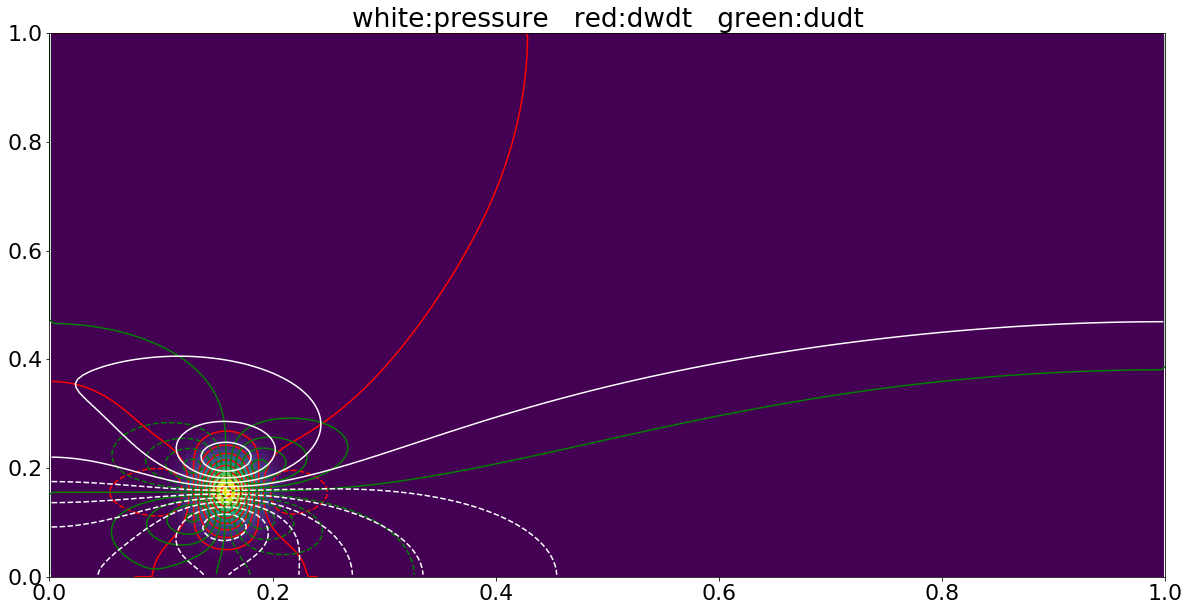

In [30]:
# Look at how pressure enforces non-divergence
# as the buoyant blob starts to rise.
quick,simple = plt.subplots(figsize=(20,10))

simple.pcolor(xw,zw,bsource)

simple.contour(xw,zw,dwdt,10,colors=['r',]) 
simple.contour(xu,zu,dudt,10,colors=['g',])
simple.contour(xp,zp,p,10,colors=['w',])
simple.set_title('white:pressure   red:dwdt   green:dudt');

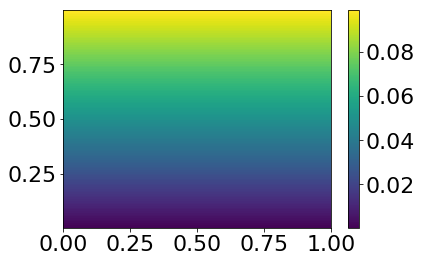

In [31]:
plt.pcolor(xu,zu,Uu); plt.colorbar()

<hr/>
## Set up the animation plot:

In [32]:
# specify paramters for the animation plot
vd = 4 # vector skip in arrow plots (vd=1 would plot all arrows)

buoylevs = np.linspace(-.05,1.05,12)
buoylevs[0] = -.25  # extend level to prevent advection errors going off the scale
buoylevs[-1] = 1.25 # extend level to prevent advection errors going off the scale
print('contour levels for buoyancy:',buoylevs)

preslevs = np.linspace(-.4,.4,80) # avoid 0 contour 
print('contour levels for pressure:',preslevs)

vortamp = 40 # for possible plotting of vorticity, change vortamp as needed
vortlevs = np.linspace(-1.05*vortamp,1.05*vortamp,22)
print('contour levels for vorticity:',vortlevs)

contour levels for buoyancy: [-0.25  0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75  0.85  0.95  1.25]
contour levels for pressure: [-0.4        -0.38987342 -0.37974684 -0.36962025 -0.35949367 -0.34936709
 -0.33924051 -0.32911392 -0.31898734 -0.30886076 -0.29873418 -0.28860759
 -0.27848101 -0.26835443 -0.25822785 -0.24810127 -0.23797468 -0.2278481
 -0.21772152 -0.20759494 -0.19746835 -0.18734177 -0.17721519 -0.16708861
 -0.15696203 -0.14683544 -0.13670886 -0.12658228 -0.1164557  -0.10632911
 -0.09620253 -0.08607595 -0.07594937 -0.06582278 -0.0556962  -0.04556962
 -0.03544304 -0.02531646 -0.01518987 -0.00506329  0.00506329  0.01518987
  0.02531646  0.03544304  0.04556962  0.0556962   0.06582278  0.07594937
  0.08607595  0.09620253  0.10632911  0.1164557   0.12658228  0.13670886
  0.14683544  0.15696203  0.16708861  0.17721519  0.18734177  0.19746835
  0.20759494  0.21772152  0.2278481   0.23797468  0.24810127  0.25822785
  0.26835443  0.27848101  0.28860759  0.29873418  0.30886076  0.31

In [33]:
# set up figure for animation during integration 
myfig = plt.figure(figsize=(20,10),facecolor='lightgrey')
ax2 = myfig.add_axes([0.1, 0.1, 0.8, .8], frameon=False) # contour axes
ax3 = myfig.add_axes([0.0, 0.1, 0.08, .8]) # for colorbar
ax3.axis('off')
ax2.axis('off')
plt.setp( ax2.get_xticklabels(), visible=False);
plt.close()
cbar_exists = False # so it will be created, once, and then remain fixed 

In [34]:
def doplot():
    global cbar_exists
    matplotlib.rcParams.update({'font.size': 22})
    ax2.clear()
    
    # Image layer 
    # CF = ax2.contourf(xb,zb,b,buoylevs,zorder=2)
    CF = ax2.pcolor(xb,zb,b)
    
    # contour vort or p:
    #vort = vortU(u,w,dx,dz)
    #ax2.contour(xU,zU,vort,vortlevs,colors=('w',),zorder=4)
    ax2.contour(xp,zp,p,preslevs,colors=('w',),zorder=4)
    
# Different flavors of pressure 
    ax2.contour(xp,zp,pdyn,preslevs,colors=('y',),zorder=4)
    ax2.contour(xp,zp,pb,preslevs,colors=('r',),zorder=4)

    ax2.axis('off')
    
    # arrows 
    up = u_to_p(u)
    wp = w_to_p(w)
    Q = ax2.quiver(xp[::vd,::vd],zp[::vd,::vd],up[::vd,::vd]*zmax/xmax,wp[::vd,::vd],
            scale=0.5*speedmax*Nx/vd,units='width',zorder=3)
    ax2.text(.5,-.05,expt,fontsize=18)
    ax2.text(.05,-.05,'t={0:5.3f}'.format(t),fontsize=22)
    speedf = "%7.3f"  % speedmax
    stop_clipping(ax2)
    ax2.quiverkey(Q,-.1,.95,speedmax,speedf,zorder=4)
    
    # set up color bar, if it wasn't already 
    if not cbar_exists:
        mycbar = myfig.colorbar(CF,ax=ax3,fraction=0.4)
        mycbar.ax.yaxis.set_ticks_position('left')
        sooner = mycbar.ax.yaxis.get_ticklabels()
        for boomer in sooner:
            boomer.set_fontsize(12)
        cbar_exists = True
        
    clear_output(wait=True)
    display(myfig)
    
    if outdir: 
        timestamp = 100*round(t,2)
        pngname = outdir+'/%06d.png' % round(timestamp) 
        myfig.savefig(pngname, dpi=72, facecolor='w', edgecolor='w', orientation='portrait')

<hr/>
## Set parameters for the numerical solution:

In [35]:
speedmax = 0.5 # estimated maximum speed that will occur
cfl = .3 # if parcel moves at speedmax, fraction of dx it is allowed to traverse 
dt = cfl*dx/speedmax # restrict dt by cfl choice
div_reduce = 0. # try 0.1
aborder = 3 # Adams-Bashforth order: 1, 2 or 3
expt = '%d,%4.2f,%7.5f' % (Nx, cfl, diffusion_coef)
print(expt)

257,0.30,0.00000


<hr>
##  Start from t=0:

In [36]:
u = Uu.copy() # Initial shear 
w = 0.*xw
p = 0.*xp
b = bsource.copy()

dudta = [None]*3
dwdta = [None]*3
dbdta = [None]*3 

nstep = 0

vstore1 = []
vstore2 = []
vstore3 = []
vstore4 = []
tstore = []

t=0. 

# doplot()

<hr/>
## Run the model:


In [37]:
tstop = 4
dplot = .1 # time between plots
tplot = t # time for next plot 
print(dt)

0.00234375


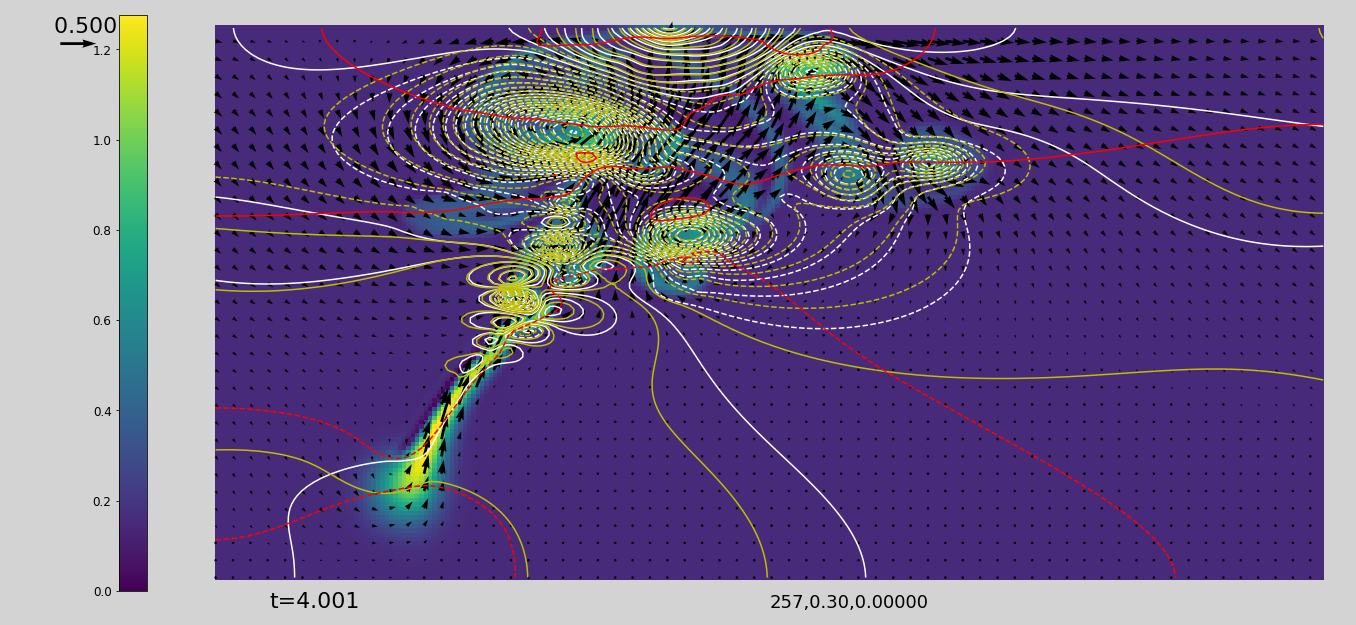

speedmax  0.8600030693561532


In [38]:
#%%prun 
# remove the above comment symbol to use %%prun
    
while t < tstop - dt/2. :
    nstep += 1
    abnow = min(nstep,aborder) 
    
    div_vel = divergence(u,w,dx,dz)
    wu = w_to_u(w)
    uw = u_to_w(u)
    
# Unchanging nackground sheared flow Uu (on u grid) and Uw (on b,w grid) advecting everything
#    dbdt = advect(b,uw+Uw,w,dx,dz) 
#    dudt = advect(u,u+Uu,wu,dx,dz)
#    dwdt = advect(w,uw+Uw,w,dx,dz) + b

    dbdt = advect(b,uw,w,dx,dz) 
    dudt = advect(u,u,wu,dx,dz)
    dwdt = advect(w,uw,w,dx,dz) + b   

    if diffusion_coef > 0.0 :
        dbdt += diffusion_coef*laplacian(b,dx,dz,il=0,ir=-1)
        dudt += diffusion_coef*laplacian(u,dx,dz,jb=0,jt=-1)
        dwdt += diffusion_coef*laplacian(w,dx,dz,il=0,ir=-1)
    div_accel = divergence(dudt,dwdt,dx,dz)
    p = poisson_p_fft(div_accel + div_reduce*div_vel/dt  , invlapl)
#    p -= p.mean() # is this kluge necessary?
    
    dudt[:,1:-1] += (p[:,:-1]-p[:,1:])/dx
    dwdt[1:-1,:] += (p[:-1,:]-p[1:,:])/dz
       
    dudta = [dudt.copy()] + dudta[:-1]
    dwdta = [dwdt.copy()] + dwdta[:-1]
    dbdta = [dbdt.copy()] + dbdta[:-1]
    
    u += dt*ab_blend(dudta,abnow) 
    w += dt*ab_blend(dwdta,abnow)
    b += dt*ab_blend(dbdta,abnow)
    
# starting plume includes a sustained buoyancy source
    b += dt*bsource 
        
    t = t + dt
    
    vstore1.append( b.max() )
    vstore2.append( abs(div_vel).max())
    tstore.append(t)
    
    assert u.max()<2.e10, 'kaboom!'

    if t > tplot - dt/2. : 
        
# Only at plotting time, display the buoyancy driven and dynamic pressures    
# diagnose b and d pressures and display them separately 
# pb, buoyancy pressure
        div_accelb = divergence(dudt*0,b,dx,dz)
        pb = poisson_p_fft(div_accelb + div_reduce*div_vel/dt  , invlapl)
#        pb -= pb.mean()

# pd, dynamic pressure due to advection by mean shearflow only
#        dudtU = advect(u,Uu,wu*0,dx,dz)
#        dwdtU = advect(w,Uw,w*0,dx,dz)
#        div_acceldU = divergence(dudtU,dwdtU,dx,dz)
#        pdynU = poisson_p_fft(div_acceldU + div_reduce*div_vel/dt  , invlapl)
#        pdyn=pdynU
# or, residual passed to plotting code 
        pdyn = p-pb
        
        doplot() # contours of pd and pb were added to doplot()
        tplot = min(tstop,tplot + dplot)
        speed = np.sqrt(u*u + wu*wu)
        print('speedmax ', speed.max())
        
plt.close() 

<a href="#initial">Set new initial conditions</a>

In [39]:
!pwd

/Users/bem/Jupyter/ATM663_convection_meso/Assignments/Notebooks/frames


In [40]:
import glob 
import imageio

path = '/Users/bem/Jupyter/ATM663_convection_meso/Assignments/Notebooks/'+outdir
print(path)
os.chdir(path)
filenames = sorted(glob.glob(path+'/*.png'))
print(filenames)
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./bubble_exp.gif', images) # convert plots into a gif movie

/Users/bem/Jupyter/ATM663_convection_meso/Assignments/Notebooks/frames
['/Users/bem/Jupyter/ATM663_convection_meso/Assignments/Notebooks/frames/000000.png', '/Users/bem/Jupyter/ATM663_convection_meso/Assignments/Notebooks/frames/000010.png', '/Users/bem/Jupyter/ATM663_convection_meso/Assignments/Notebooks/frames/000020.png', '/Users/bem/Jupyter/ATM663_convection_meso/Assignments/Notebooks/frames/000030.png', '/Users/bem/Jupyter/ATM663_convection_meso/Assignments/Notebooks/frames/000040.png', '/Users/bem/Jupyter/ATM663_convection_meso/Assignments/Notebooks/frames/000050.png', '/Users/bem/Jupyter/ATM663_convection_meso/Assignments/Notebooks/frames/000060.png', '/Users/bem/Jupyter/ATM663_convection_meso/Assignments/Notebooks/frames/000070.png', '/Users/bem/Jupyter/ATM663_convection_meso/Assignments/Notebooks/frames/000080.png', '/Users/bem/Jupyter/ATM663_convection_meso/Assignments/Notebooks/frames/000090.png', '/Users/bem/Jupyter/ATM663_convection_meso/Assignments/Notebooks/frames/000100

## Animated gif result

<tr>
<td><img src='/Users/bem/Jupyter/ATM663_convection_meso/Assignments/Notebooks/frames/bubble_exp.gif' width="800" height="400"><td>
<tr>

!/Users/bem/Jupyter/ATM663_convection_meso/Assignments/Notebooks/frames/bubble_exp.gif

In [25]:
![ChessUrl](https://upload.wikimedia.org/wikipedia/commons/7/71/ChessPawnSpecialMoves.gif "chess")

/bin/sh: -c: line 0: syntax error near unexpected token `https://upload.wikimedia.org/wikipedia/commons/7/71/ChessPawnSpecialMoves.gif'
/bin/sh: -c: line 0: `[ChessUrl](https://upload.wikimedia.org/wikipedia/commons/7/71/ChessPawnSpecialMoves.gif "chess")'


In [26]:
from IPython.display import HTML
HTML('<img src="/Users/bem/Jupyter/ATM663_convection_meso/Assignments/Notebooks/frames/bubble_exp.gif">')